# 変化点検出

In [17]:
import numpyro
import numpyro.distributions as dist

import arviz as az

import jax
import jax.numpy as jnp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')

In [3]:
# 判定させるデータの生成

r0 = 2
r1 = 1

years = np.arange(1851, 1970)
switchpoint = 1890

r = np.where(years <= switchpoint, r0, r1)
count = dist.Poisson(r).sample(jax.random.PRNGKey(0))

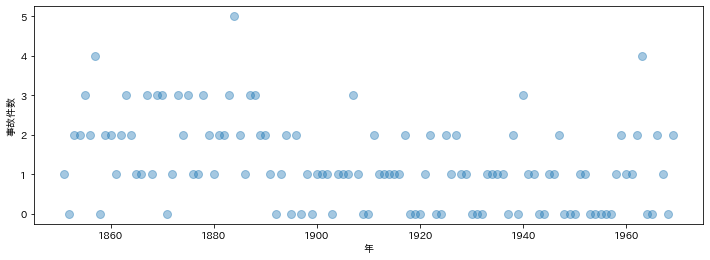

In [18]:
fig = plt.figure(figsize=(12,4))

plt.plot(years, count, "o", markersize=8, alpha=0.4)

plt.xlabel("年")
plt.ylabel("事故件数");

In [6]:
years = jnp.array(years)
count = jnp.array(count)

## モデリング
- データは年数$x_n$と事故件数$y_n$の組み合わせ
$$
D= \{X,Y\}
$$


- 観測モデル
$$
y_n \sim Poi(y_n|\lambda)
$$

$\lambda$をドローする分布は以下のStep関数で決定的に決まる
$$
\lambda=
\left\{
\begin{array}{ll}
\lambda \sim p(r_0) & (x_n < f(s_n)) \\
\lambda \sim p(r_1) & (x_n \geq f(s_n))
\end{array}
\right.
$$
$f$はラベルから年数への射影

$s_n$はカテゴリカル分布に従うラベルの変数
$$
s_n \sim Cat(s_n|\pi)
$$

In [21]:
def model(years, count=None):
    n = len(years)
    
    #piの事前分布の一様分布（固定？）
    p = jnp.ones(n)/n
    s = numpyro.sample("switchpoint_index", dist.Categorical(p))
    
    # ”年数”の変数（インデックスの方が確率変数で、そっから確定的に決まる変数だが、名前付けとくと後で取り出しやすい）
    switchpoint = numpyro.deterministic("switchpoint", years[s])

    # step関数で変化するポアソン分布の平均の事前分布
    r0 = numpyro.sample("r0", dist.HalfNormal(10))
    r1 = numpyro.sample("r1", dist.HalfNormal(10))
    
    #step関数
    r_switched = numpyro.deterministic("r_switched", jnp.where(years <= switchpoint, r0, r1))
    
    # ポアソン分布で観測モデルを定義
    numpyro.sample("obs", dist.Poisson(r_switched), obs=count)    

In [9]:
nuts = numpyro.infer.NUTS(model, target_accept_prob=0.99)
kernel = numpyro.infer.DiscreteHMCGibbs(nuts)

mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=3000, num_chains=3)

mcmc.run(jax.random.PRNGKey(1), years, count)
trace = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/tmp/ipykernel_52825/1479898318.py:4: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=3000, num_chains=3)
sample: 100%|█| 3500/3500 [00:05<00:00, 624.14it/s, 7 steps of size 3.38e-01. ac
sample: 100%|█| 3500/3500 [00:02<00:00, 1240.45it/s, 7 steps of size 3.20e-01. a
sample: 100%|█| 3500/3500 [00:02<00:00, 1203.34it/s, 15 steps of size 3.24e-01. 


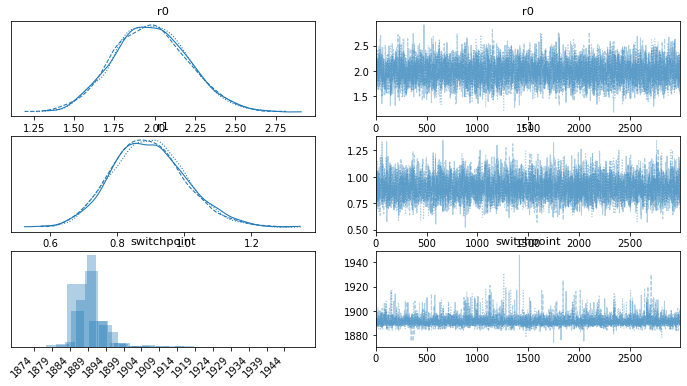

In [11]:
axes = az.plot_trace(idata, var_names=["r0", "r1", "switchpoint"])
plt.setp(axes[2, 0].get_xticklabels(), rotation=45, ha="right");

In [12]:
az.summary(idata, var_names=["r0", "r1", "switchpoint"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r0,1.977,0.231,1.547,2.414,0.003,0.002,4348.0,3902.0,1.0
r1,0.895,0.110,0.699,1.108,0.002,0.001,4399.0,4253.0,1.0
switchpoint,1891.297,3.800,1885.000,1897.000,0.048,0.034,6755.0,7129.0,1.0


In [13]:
switchpoint_mean = trace["switchpoint"].mean(axis=0)
r_switched_mean = trace["r_switched"].mean(axis=0)

In [16]:
hdi = az.hdi(idata, hdi_prob=0.95)
switchpoint_hdi = hdi["switchpoint"]

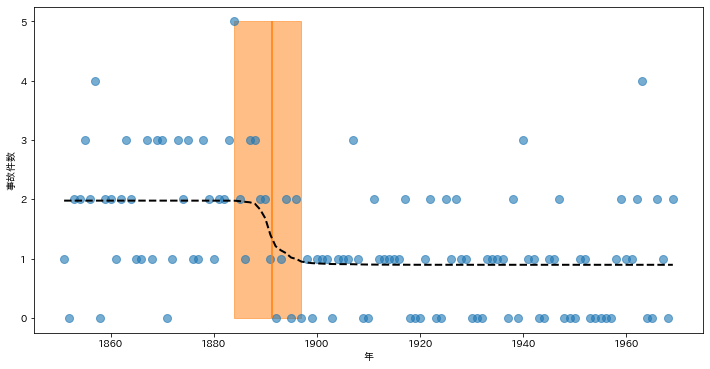

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(years, count, "o",  markersize=8, alpha=0.6)
plt.ylabel("事故件数")
plt.xlabel("年")

plt.vlines(switchpoint_mean, count.min(), count.max(), color="C1")
plt.fill_betweenx(y=[count.min(), count.max()], x1=switchpoint_hdi[0], x2=switchpoint_hdi[1], alpha=0.5, color="C1")

plt.plot(years, r_switched_mean, "k--", linewidth=2);